# Test 

### Feature selection

In [81]:
import pandas as pd

df_test = pd.read_parquet("data/test.parquet")

### Function

In [82]:
def create_test_featuresV4(df_test, lookback_days=15, batch_size=1000):
    """
    Creates aggregated features for churn prediction (V4 - CLEANED VERSION).
    Removed redundant/low-importance features from V3.
    """
    
    print("Starting feature engineering V4 (cleaned version)...")
    
    # Copy and optimize data types
    df = df_test.copy()
    
    print("Optimizing data types...")
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start']
    
    # Pre-compute window boundaries
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    session_info['days_since_registration'] = (
        (session_info['session_start'] - session_info['registration']).dt.total_seconds() / 86400
    ).clip(lower=0)
    
    print(f"Processing {len(session_info):,} sessions in batches of {batch_size} users...")
    
    unique_users = session_info['userId'].unique()
    n_batches = int(np.ceil(len(unique_users) / batch_size))
    all_results = []
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_users))
        batch_users = unique_users[start_idx:end_idx]
        
        batch_df = df[df['userId'].isin(batch_users)].copy()
        batch_sessions = session_info[session_info['userId'].isin(batch_users)].copy()
        batch_df = batch_df.sort_values(['userId', 'time'])
        
        batch_results = []
        
        for user_id, user_sessions in batch_sessions.groupby('userId', observed=True):
            user_logs = batch_df[batch_df['userId'] == user_id]
            
            if len(user_logs) == 0:
                continue
            
            user_times = user_logs['time'].values
            user_pages = user_logs['page'].values
            user_session_ids = user_logs['sessionId'].values
            user_item_in_session = user_logs['itemInSession'].values if 'itemInSession' in user_logs.columns else None
            
            for session_row in user_sessions.itertuples(index=False):
                session_id = session_row.sessionId
                session_start = session_row.session_start
                registration_date = session_row.registration
                window_start = session_row.window_start
                window_end = session_row.window_end
                days_since_registration = session_row.days_since_registration
                
                # Exclude current session
                exclude_current_session = user_session_ids != session_id
                
                # Window mask
                window_mask = (
                    (user_times >= window_start) & 
                    (user_times < window_end) & 
                    exclude_current_session
                )
                
                window_pages = user_pages[window_mask]
                window_times = user_times[window_mask]
                window_session_ids = user_session_ids[window_mask]
                if user_item_in_session is not None:
                    window_item_in_session = user_item_in_session[window_mask]
                else:
                    window_item_in_session = None
                
                # Calculate inactivity
                previous_mask = (user_times < window_end) & exclude_current_session
                previous_times = user_times[previous_mask]
                
                if len(previous_times) > 0:
                    last_action_time = pd.Timestamp(previous_times[-1])
                    hours_since_last_action = (session_start - last_action_time).total_seconds() / 3600
                else:
                    hours_since_last_action = (session_start - registration_date).total_seconds() / 3600
                
                # Page counting
                if len(window_pages) > 0:
                    unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                    page_count_dict = dict(zip(unique_pages, page_counts))
                else:
                    page_count_dict = {}
                
                def get_count(page_name):
                    return page_count_dict.get(page_name, 0)
                
                total_actions = len(window_pages)
                num_sessions = len(np.unique(window_session_ids)) if total_actions > 0 else 0
                
                # Calculate key metrics
                count_next_song = get_count('NextSong')
                count_thumbs_up = get_count('Thumbs Up')
                
                # Skip rate calculation
                skip_count = 0
                if window_item_in_session is not None and len(window_item_in_session) > 1:
                    nextsong_mask = window_pages == 'NextSong'
                    nextsong_sessions = window_session_ids[nextsong_mask]
                    nextsong_items = window_item_in_session[nextsong_mask]
                    
                    for sess_id in np.unique(nextsong_sessions):
                        sess_items = nextsong_items[nextsong_sessions == sess_id]
                        if len(sess_items) > 1:
                            diffs = np.diff(sess_items)
                            skip_count += np.sum(diffs > 1)
                
                # Previous week for variation
                previous_week_start = window_start - pd.Timedelta(days=7)
                previous_week_end = window_start
                
                previous_week_mask = (
                    (user_times >= previous_week_start) & 
                    (user_times < previous_week_end) & 
                    exclude_current_session
                )
                
                previous_week_pages = user_pages[previous_week_mask]
                previous_week_actions = len(previous_week_pages)
                
                # Activity variation
                if previous_week_actions > 0:
                    activity_variation = ((total_actions - previous_week_actions) / previous_week_actions) * 100
                else:
                    activity_variation = 0 if total_actions == 0 else 100
                
                # Music consumption variation
                if len(previous_week_pages) > 0:
                    prev_unique, prev_counts = np.unique(previous_week_pages, return_counts=True)
                    prev_dict = dict(zip(prev_unique, prev_counts))
                    previous_week_songs = prev_dict.get('NextSong', 0)
                else:
                    previous_week_songs = 0
                
                if previous_week_songs > 0:
                    music_consumption_variation = ((count_next_song - previous_week_songs) / previous_week_songs) * 100
                else:
                    music_consumption_variation = 0 if count_next_song == 0 else 100
                
                # Features
                features = {
                    'sessionId': session_id,
                    'userId': str(user_id),
                    'session_start': session_start,
                    'registration': registration_date,
                    
                    # Temporal
                    'hours_since_last_action': hours_since_last_action,
                    'days_since_registration': days_since_registration,
                    
                    # Actions
                    'count_help': get_count('Help'),
                    'count_about': get_count('About'),
                    'count_error': get_count('Error'),
                    'count_thumbs_down': get_count('Thumbs Down'),
                    'count_add_friend': get_count('Add Friend'),
                    'count_settings': get_count('Settings'),
                    'count_save_settings': get_count('Save Settings'),
                    'count_downgrade': get_count('Downgrade'),
                    'count_upgrade': get_count('Upgrade'),
                    'count_submit_downgrade': get_count('Submit Downgrade'),
                    'count_submit_upgrade': get_count('Submit Upgrade'),
                    'count_roll_advert': get_count('Roll Advert'),
                    
                    # Global
                    'total_actions': total_actions,
                    'num_sessions': num_sessions,
                    
                    # Key ratios
                    'skip_rate': skip_count / count_next_song if count_next_song > 0 else 0,
                    'like_ratio': count_thumbs_up / count_next_song if count_next_song > 0 else 0,
                    
                    # Variations
                    'activity_variation_pct': activity_variation,
                    'music_consumption_variation_pct': music_consumption_variation,
                    'previous_week_actions': previous_week_actions,
                    
                    # Flags
                    'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                    'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                    'has_negative_engagement': int(get_count('Thumbs Down') > 0),
                }
                
                batch_results.append(features)
        
        all_results.extend(batch_results)
        
        if (batch_idx + 1) % 10 == 0 or batch_idx == n_batches - 1:
            print(f"  Processed batch {batch_idx + 1}/{n_batches} ({len(all_results):,} sessions so far)")
    
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")

    return df_features

In [83]:
# Trouver l'utilisateur avec le plus de sessions
sessions_per_user = df_test.groupby('userId')['sessionId'].nunique().sort_values(ascending=False)

# Le top 1
max_user = sessions_per_user.index[0]
max_sessions = sessions_per_user.iloc[0]

print(f"User with most sessions: {max_user}")
print(f"Number of sessions: {max_sessions}")

# Top 10 pour comparaison
print(f"\nTop 10 users by session count:")
print(sessions_per_user.head(10))

# Distribution
print(f"\nDistribution:")
print(f"  Mean: {sessions_per_user.mean():.1f}")
print(f"  Median: {sessions_per_user.median():.1f}")
print(f"  Max: {sessions_per_user.max()}")

User with most sessions: 1261737
Number of sessions: 134438

Top 10 users by session count:
userId
1261737    134438
1116029       112
1979129        99
1663631        97
1703411        96
1165912        96
1620250        87
1560060        87
1019103        86
1042376        84
Name: sessionId, dtype: int64

Distribution:
  Mean: 61.3
  Median: 11.0
  Max: 134438


In [84]:
user_data = df_test[df_test['userId'] == '1261737']
user_data


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
17,200,None,None,paid,None,1261737,1538352008000,Logged Out,Home,8615,None,87,None,GET,NaN,None,None,2018-10-01 00:00:08,2018-10-01 00:00:08
71,307,None,None,free,None,1261737,1538352041000,Logged Out,Login,7433,None,0,None,PUT,NaN,None,None,2018-10-01 00:00:41,2018-10-01 00:00:08
354,200,None,None,free,None,1261737,1538352182000,Logged Out,Home,25003,None,4,None,GET,NaN,None,None,2018-10-01 00:03:02,2018-10-01 00:00:08
472,200,None,None,free,None,1261737,1538352254000,Logged Out,Home,9930,None,2,None,GET,NaN,None,None,2018-10-01 00:04:14,2018-10-01 00:00:08
476,307,None,None,free,None,1261737,1538352255000,Logged Out,Login,9930,None,3,None,PUT,NaN,None,None,2018-10-01 00:04:15,2018-10-01 00:00:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25661418,200,None,None,paid,None,1261737,1542671712000,Logged Out,Home,37204,None,29,None,GET,NaN,None,None,2018-11-19 23:55:12,2018-10-01 00:00:08
25661455,200,None,None,paid,None,1261737,1542671748000,Logged Out,About,37204,None,30,None,GET,NaN,None,None,2018-11-19 23:55:48,2018-10-01 00:00:08
25661460,307,None,None,paid,None,1261737,1542671749000,Logged Out,Login,37204,None,31,None,PUT,NaN,None,None,2018-11-19 23:55:49,2018-10-01 00:00:08
25661574,200,None,None,paid,None,1261737,1542671906000,Logged Out,Home,37204,None,35,None,GET,NaN,None,None,2018-11-19 23:58:26,2018-10-01 00:00:08


In [85]:
data_clean = df_test[df_test['userId'] != '1261737']


In [86]:
data_clean.columns

Index(['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts',
       'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent',
       'method', 'length', 'song', 'artist', 'time', 'registration'],
      dtype='object')

In [87]:
df_test_features = create_test_featuresV4(data_clean, lookback_days=60, batch_size=1000)

Starting feature engineering V4 (cleaned version)...
Optimizing data types...
Dataset size: 3,739,498 logs
Users: 2,903, Sessions: 41,384
Extracting session information...
Processing 41,384 sessions in batches of 1000 users...
  Processed batch 3/3 (41,384 sessions so far)
Creating final dataframe...

✓ Final dataset: 41,384 rows, 23 features
Label distribution:


### Predict

In [88]:
model_rf_SMOTED

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

In [89]:
def predict_churn(model, df_test_features):
    """
    Predict churn on test data using trained model.
    
    Parameters:
    -----------
    model : trained RandomForestClassifier
        Model from random_forest_training()
    df_test_features : pd.DataFrame
        Output from create_features_test()
    
    Returns:
    --------
    pd.DataFrame with predictions
    """
    
    # Prepare features (same as training)
    feature_cols = [col for col in df_test_features.columns 
                   if col not in ['userId', 'session_start', 'registration']]
    
    X_test = df_test_features[feature_cols].fillna(0)
    
    print(f"Predicting on {len(X_test):,} sessions...")
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Create results dataframe
    results = df_test_features[['userId']].copy()
    results['predicted_churn'] = y_pred
    #results['churn_probability'] = y_pred_proba
    
    print(f"\nPredictions:")
    print(f"  Will churn (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.1f}%)")
    print(f"  No churn (0):   {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.1f}%)")
    
    #print(f"\nAverage churn probability: {y_pred_proba.mean():.3f}")
    #print(f"High risk (prob > 0.7): {(y_pred_proba > 0.7).sum():,}")
    
    return results

In [90]:
# 3. Predict
submission = predict_churn(model_rf_SMOTED, df_test_features)

Predicting on 41,384 sessions...

Predictions:
  Will churn (1): 9,194 (22.2%)
  No churn (0):   32,190 (77.8%)


In [91]:
# Créer une ligne pour user 1261737
new_row = pd.DataFrame({
    'userId': ['1261737'],
    'predicted_churn': [0]
})

# Ajouter à ton submission
submission_complete = pd.concat([submission, new_row], ignore_index=True)

print(f"Submission before: {len(submission)} rows")
print(f"Submission after: {len(submission_complete)} rows")

# Vérifier
print(f"\nUser 1261737 in submission: {'1261737' in submission_complete['userId'].values}")

# Sauvegarder
submission_complete.to_csv('submission_complete.csv', index=False)

Submission before: 41384 rows
Submission after: 41385 rows

User 1261737 in submission: True


In [92]:
# Renommer les colonnes pour Kaggle
submission_final = submission_complete.rename(columns={
    'userId': 'id',
    'predicted_churn': 'target'
})

# Vérifier
print("Submission structure:")
print(submission_final.head())
print(f"\nColumns: {submission_final.columns.tolist()}")
print(f"Shape: {submission_final.shape}")

# Vérifier pas de null
print(f"\nNull values: {submission_final.isnull().sum()}")

# Sauvegarder
submission_final.to_csv('submission.csv', index=False)
print("\n✓ Submission ready with columns: id, target")

Submission structure:
        id  target
0  1000963       0
1  1000963       0
2  1000963       0
3  1000963       0
4  1000963       1

Columns: ['id', 'target']
Shape: (41385, 2)

Null values: id        0
target    0
dtype: int64

✓ Submission ready with columns: id, target


In [93]:
# Grouper par userId : 1 si au moins un 1, sinon 0
submission_final = submission_final.groupby('id').agg({
    'target': 'max'  # max = 1 si au moins un 1, sinon 0
}).reset_index()

print(f"After deduplication: {len(submission_final)} unique users")
print(f"\nTarget distribution:")
print(submission_final['target'].value_counts())

# Vérifier plus de duplicates
print(f"\nDuplicates: {submission_final['id'].duplicated().sum()}")

# Sauvegarder
submission_final.to_csv('submission.csv', index=False)
print("\n Clean submission saved!")

After deduplication: 2886 unique users

Target distribution:
target
0    1479
1    1407
Name: count, dtype: int64

Duplicates: 0

 Clean submission saved!


In [94]:
# 1. Identifier les userId manquants
expected_users = df_test['userId'].unique()
submitted_users = submission_final['id'].unique()

print(f"Expected users: {len(expected_users)}")
print(f"Submitted users: {len(submitted_users)}")

# Trouver les manquants
missing_users = set(expected_users) - set(submitted_users)
print(f"\nMissing users: {len(missing_users)}")
print(f"Missing user IDs: {list(missing_users)[:10]}")  # Afficher les 10 premiers

# 2. Créer des lignes pour les utilisateurs manquants (avec target=0)
missing_rows = pd.DataFrame({
    'id': list(missing_users),
    'target': 0
})

# 3. Ajouter à la submission
submission_complete = pd.concat([submission_final, missing_rows], ignore_index=True)

print(f"\nBefore adding missing: {len(submission_final)} rows")
print(f"After adding missing: {len(submission_complete)} rows")

# 4. Vérifier qu'on a bien 2904
assert len(submission_complete) == 2904, f"Expected 2904, got {len(submission_complete)}"

# 5. Trier par id (optionnel mais propre)
submission_complete = submission_complete.sort_values('id').reset_index(drop=True)

# 6. Sauvegarder
submission_complete.to_csv('submission.csv', index=False)
print("\n✓ Complete submission with all 2904 users saved!")

Expected users: 2904
Submitted users: 2886

Missing users: 18
Missing user IDs: ['1474758', '1940610', '1311784', '1900229', '1805463', '1973354', '1681149', '1758614', '1222773', '1420493']

Before adding missing: 2886 rows
After adding missing: 2904 rows

✓ Complete submission with all 2904 users saved!


# Train

The competition is to be performed in groups of two. You'll have a report of 4 pages to submit by december 14th, presenting the methods you tested and used. For the defense you'll get 8 minutes of presentations + 7 minutes of questions, including on question on the labs, that may involve writing a code snippet.


Churn prediction 25/26
**Predict churn prediction from streaming service logs**

The goal of the competition is to predict whether or not some users (whose user ids are in the test file) will **churn in the window of 10 days that follows the given observations (ie after "2018-11-20")**. We consider that a user churns when they visit the page **'Cancellation Confirmation'** (edited) 


In [56]:
import pandas as pd

df_train_test = pd.read_parquet("data/test.parquet")
df_train = pd.read_parquet("data/train.parquet")

In [95]:
# Supprimer users qui churnent dans les 7 premiers jours
churners = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
churners['days_since_start'] = (churners['time'] - df_train['time'].min()).dt.days
early_churners = churners[churners['days_since_start'] <= 7]['userId'].unique()

df_train = df_train[~df_train['userId'].isin(early_churners)]

print(f"Avant: {df_train['userId'].nunique()}, Après: {df_train['userId'].nunique()}, Supprimé: {len(early_churners)}")

Avant: 18048, Après: 18048, Supprimé: 836


In [58]:
df_train_test

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
7,200,M,Jonathan,free,Martin,1465194,1538352006000,Logged In,NextSong,22483,"New York-Newark-Jersey City, NY-NJ-PA",29,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,250.82730,Mockingbird,Eminem,2018-10-01 00:00:06,2018-09-27 17:29:36
54,200,M,Jonathan,free,Martin,1465194,1538352028000,Logged In,Roll Advert,22483,"New York-Newark-Jersey City, NY-NJ-PA",30,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",GET,NaN,None,None,2018-10-01 00:00:28,2018-09-27 17:29:36
477,200,M,Jonathan,free,Martin,1465194,1538352256000,Logged In,NextSong,22483,"New York-Newark-Jersey City, NY-NJ-PA",31,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,355.78730,Thank You (Precious Memories Album Version),Ray Boltz,2018-10-01 00:04:16,2018-09-27 17:29:36
1170,200,M,Jonathan,free,Martin,1465194,1538352611000,Logged In,NextSong,22483,"New York-Newark-Jersey City, NY-NJ-PA",32,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,191.68608,Mathletics,Foals,2018-10-01 00:10:11,2018-09-27 17:29:36
1552,200,M,Jonathan,free,Martin,1465194,1538352802000,Logged In,NextSong,22483,"New York-Newark-Jersey City, NY-NJ-PA",33,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,275.25179,Proceed,The Roots,2018-10-01 00:13:22,2018-09-27 17:29:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25660576,200,F,Lariyah,free,Lamb,1394356,1542670678000,Logged In,NextSong,2540,"Medford, OR",122,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",PUT,312.63302,One Headlight,The Wallflowers,2018-11-19 23:37:58,2018-11-19 16:36:59
25660839,200,F,Lariyah,free,Lamb,1394356,1542670990000,Logged In,NextSong,2540,"Medford, OR",123,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",PUT,222.30159,First Dance,Justin Bieber / Usher,2018-11-19 23:43:10,2018-11-19 16:36:59
25661027,200,F,Lariyah,free,Lamb,1394356,1542671212000,Logged In,NextSong,2540,"Medford, OR",124,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",PUT,447.42485,One,Metallica,2018-11-19 23:46:52,2018-11-19 16:36:59
25661312,200,F,Lariyah,free,Lamb,1394356,1542671574000,Logged In,Upgrade,2540,"Medford, OR",125,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",GET,NaN,None,None,2018-11-19 23:52:54,2018-11-19 16:36:59


In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17499636 entries, 0 to 25661583
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   status         int64         
 1   gender         object        
 2   firstName      object        
 3   level          object        
 4   lastName       object        
 5   userId         object        
 6   ts             int64         
 7   auth           object        
 8   page           object        
 9   sessionId      int64         
 10  location       object        
 11  itemInSession  int64         
 12  userAgent      object        
 13  method         object        
 14  length         float64       
 15  song           object        
 16  artist         object        
 17  time           datetime64[us]
 18  registration   datetime64[us]
dtypes: datetime64[us](2), float64(1), int64(4), object(12)
memory usage: 2.6+ GB


In [60]:
# Creating cancellation in following ten days column

import numpy as np

cancellation_events = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
cancellation_events = cancellation_events[['userId', 'time']].rename(columns={'time': 'churn_time'})

df_train = df_train.merge(cancellation_events, on='userId', how='left')

df_train['days_until_churn'] = (df_train['churn_time'] - df_train['time']).dt.total_seconds() / (24 * 3600)

df_train['will_churn_10days'] = ((df_train['days_until_churn'] >= 0) & 
                                   (df_train['days_until_churn'] <= 10)).astype(int)

df_train = df_train.drop(['churn_time', 'days_until_churn'], axis=1)

In [61]:
df_train.describe() #max time is 2018-11-20 so we are going to keep only the rows that are at least 10 days old OR that have churn True

df_train = df_train[(df_train["time"] < "2018-11-10" )| (df_train["will_churn_10days"] == 1)]

In [62]:
# create a dataset for free users and paying users

df_train_free = df_train[df_train["level"] == "free"].copy()
df_train_paid = df_train[df_train["level"] == "paid"].copy()

In [63]:
df_train_paid.sample(10)

users_free = df_train_free["userId"]
users_paid = df_train_paid["userId"]

overlap = users_free[users_free.isin(users_paid)]
print(f"Number of overlapping users: {overlap.nunique()}")
print(f"Total number of users {df_train["userId"].nunique()}")


#Lots of users that switch from free to paid 

Number of overlapping users: 9244
Total number of users 18884


In [64]:
#Checking that code worked as expected
df_train.sort_values(by='time', ascending = True).head(10)

#!!!!!!!
# Since we only keep rows that have churn True in the last 10 days, our model could learn that a later date means more chance to churn! MERDE


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration,will_churn_10days
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,0
15193945,200,M,Austen,free,Horton,1484921,1538352001000,Logged In,NextSong,2436,"New York-Newark-Jersey City, NY-NJ-PA",73,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",PUT,238.54975,Just Dance,Lady GaGa / Colby O'Donis,2018-10-01 00:00:01,2018-09-16 09:11:42,0
15194608,200,M,Jose,free,Goodman,1694515,1538352001000,Logged In,NextSong,2466,"Lafayette, LA",1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,231.65342,Give It Up (Album Version),The Format,2018-10-01 00:00:01,2018-09-15 04:03:02,0
1796,200,F,Vina,paid,Bailey,1697168,1538352002000,Logged In,NextSong,4593,"Hilo, HI",109,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,PUT,140.35546,Baby Talk,Lush,2018-10-01 00:00:02,2018-09-08 13:48:25,0
1223,200,F,Vianney,paid,Miller,1563081,1538352002000,Logged In,NextSong,20836,"San Francisco-Oakland-Hayward, CA",9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,238.39302,MiÃÂ©ntele,Los Bunkers,2018-10-01 00:00:02,2018-09-21 03:25:18,0
15195378,200,F,Noeli,free,Harrison,1379661,1538352003000,Logged In,NextSong,133,"Dallas-Fort Worth-Arlington, TX",140,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,241.24036,All Along The Watchtower,Jimi Hendrix,2018-10-01 00:00:03,2018-07-26 17:36:54,0
15198031,200,F,Samantha,paid,Villanueva,1252007,1538352003000,Logged In,Home,3935,"Fort Collins, CO",36,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,GET,NaN,None,None,2018-10-01 00:00:03,2018-07-19 15:35:33,0
5924,200,F,Aaliyah,paid,Ramirez,1714398,1538352003000,Logged In,NextSong,22316,"Baltimore-Columbia-Towson, MD",21,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,1121.25342,Close To The Edge (I. The Solid Time Of Change...,Yes,2018-10-01 00:00:03,2018-09-19 18:23:35,0
3761,200,M,Andres,paid,Foley,1222580,1538352003000,Logged In,NextSong,6370,"Watertown, SD",71,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,277.15873,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,2018-10-01 00:00:03,2018-08-16 02:31:00,0
15195379,307,F,Noeli,free,Harrison,1379661,1538352004000,Logged In,Logout,133,"Dallas-Fort Worth-Arlington, TX",141,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,NaN,None,None,2018-10-01 00:00:04,2018-07-26 17:36:54,0


In [65]:
df_train.describe()

,status,ts,sessionId,itemInSession,length,time,registration,will_churn_10days
count,1.465755e+07,1.465755e+07,1.465755e+07,1.465755e+07,1.195098e+07,14657548,14657548,1.465755e+07
mean,2.091415e+02,1.540076e+12,7.294373e+04,1.045211e+02,2.487060e+02,2018-10-20 22:51:07.219720,2018-08-25 02:18:34.093644,1.235250e-01
min,2.000000e+02,1.538352e+12,1.000000e+00,0.000000e+00,5.220000e-01,2018-10-01 00:00:01,2017-10-14 22:05:25,0.000000e+00
25%,2.000000e+02,1.539193e+12,2.127200e+04,2.500000e+01,1.998624e+02,2018-10-10 17:35:49.750000,2018-08-10 22:00:31,0.000000e+00
50%,2.000000e+02,1.540025e+12,6.789700e+04,6.500000e+01,2.340828e+02,2018-10-20 08:43:09,2018-09-05 15:53:20,0.000000e+00
75%,2.000000e+02,1.540941e+12,1.190990e+05,1.420000e+02,2.768714e+02,2018-10-30 23:12:18,2018-09-20 15:27:40,0.000000e+00
max,4.040000e+02,1.542672e+12,2.047110e+05,1.426000e+03,3.024666e+03,2018-11-19 23:55:09,2018-11-14 23:31:27,1.000000e+00
std,3.023523e+01,1.020072e+09,5.300614e+04,1.165782e+02,9.725864e+01,NaN,NaN,3.290388e-01


## Feature preprocessing

In [66]:
# Sampling the dataset to try the functions:
sample_users = df_train['userId'].drop_duplicates().sample(n=1000, random_state=42)
sample_df_train = df_train[df_train['userId'].isin(sample_users)].copy()

# Selection of columns to simplify the dataset
columns_selection = ['userId', 'time', 'page', 'registration', 'sessionId',
              'itemInSession', 'will_churn_10days']
sample_df_train = sample_df_train[columns_selection]
sample_df_train.sample(10)

,userId,time,page,registration,sessionId,itemInSession,will_churn_10days
9537953,1923764,2018-10-14 22:48:20,NextSong,2018-09-30 09:08:13,74673,7,0
4254959,1414935,2018-10-06 13:05:37,NextSong,2018-08-07 17:21:57,48454,156,0
6277919,1425609,2018-11-04 11:42:14,Add Friend,2018-09-23 06:06:26,155565,92,0
8751652,1958967,2018-10-08 14:12:33,NextSong,2018-07-18 11:32:18,40579,252,0
9966153,1478874,2018-10-14 10:42:35,NextSong,2018-09-29 13:53:48,69213,1023,0
5916892,1743226,2018-10-09 08:19:11,Add to Playlist,2018-08-24 07:17:16,44576,9,0
10404987,1705860,2018-10-29 12:42:38,NextSong,2018-09-26 00:47:00,128363,45,0
10583196,1375024,2018-10-11 01:56:56,NextSong,2018-09-11 23:16:37,47696,212,0
9715240,1505822,2018-10-10 17:03:57,NextSong,2018-06-09 10:54:32,61366,6,1
16533134,1830029,2018-10-24 21:49:46,NextSong,2018-08-14 20:52:40,19696,341,0


### Optimized function

### Current function

In [67]:
def create_featuresV4(df_train, lookback_days=15, batch_size=1000):
    """
    Creates aggregated features for churn prediction (V4 - CLEANED VERSION).
    Removed redundant/low-importance features from V3.
    """
    
    print("Starting feature engineering V4 (cleaned version)...")
    
    # Copy and optimize data types
    df = df_train.copy()
    
    print("Optimizing data types...")
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first',
        'will_churn_10days': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start', 'will_churn_10days']
    
    # Pre-compute window boundaries
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    session_info['days_since_registration'] = (
        (session_info['session_start'] - session_info['registration']).dt.total_seconds() / 86400
    ).clip(lower=0)
    
    print(f"Processing {len(session_info):,} sessions in batches of {batch_size} users...")
    
    unique_users = session_info['userId'].unique()
    n_batches = int(np.ceil(len(unique_users) / batch_size))
    all_results = []
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_users))
        batch_users = unique_users[start_idx:end_idx]
        
        batch_df = df[df['userId'].isin(batch_users)].copy()
        batch_sessions = session_info[session_info['userId'].isin(batch_users)].copy()
        batch_df = batch_df.sort_values(['userId', 'time'])
        
        batch_results = []
        
        for user_id, user_sessions in batch_sessions.groupby('userId', observed=True):
            user_logs = batch_df[batch_df['userId'] == user_id]
            
            if len(user_logs) == 0:
                continue
            
            user_times = user_logs['time'].values
            user_pages = user_logs['page'].values
            user_session_ids = user_logs['sessionId'].values
            user_item_in_session = user_logs['itemInSession'].values if 'itemInSession' in user_logs.columns else None
            
            for session_row in user_sessions.itertuples(index=False):
                session_id = session_row.sessionId
                session_start = session_row.session_start
                registration_date = session_row.registration
                label = session_row.will_churn_10days
                window_start = session_row.window_start
                window_end = session_row.window_end
                days_since_registration = session_row.days_since_registration
                
                # Exclude current session
                exclude_current_session = user_session_ids != session_id
                
                # Window mask
                window_mask = (
                    (user_times >= window_start) & 
                    (user_times < window_end) & 
                    exclude_current_session
                )
                
                window_pages = user_pages[window_mask]
                window_times = user_times[window_mask]
                window_session_ids = user_session_ids[window_mask]
                if user_item_in_session is not None:
                    window_item_in_session = user_item_in_session[window_mask]
                else:
                    window_item_in_session = None
                
                # Calculate inactivity
                previous_mask = (user_times < window_end) & exclude_current_session
                previous_times = user_times[previous_mask]
                
                if len(previous_times) > 0:
                    last_action_time = pd.Timestamp(previous_times[-1])
                    hours_since_last_action = (session_start - last_action_time).total_seconds() / 3600
                else:
                    hours_since_last_action = (session_start - registration_date).total_seconds() / 3600
                
                # Page counting
                if len(window_pages) > 0:
                    unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                    page_count_dict = dict(zip(unique_pages, page_counts))
                else:
                    page_count_dict = {}
                
                def get_count(page_name):
                    return page_count_dict.get(page_name, 0)
                
                total_actions = len(window_pages)
                num_sessions = len(np.unique(window_session_ids)) if total_actions > 0 else 0
                
                # Calculate key metrics
                count_next_song = get_count('NextSong')
                count_thumbs_up = get_count('Thumbs Up')
                
                # Skip rate calculation
                skip_count = 0
                if window_item_in_session is not None and len(window_item_in_session) > 1:
                    nextsong_mask = window_pages == 'NextSong'
                    nextsong_sessions = window_session_ids[nextsong_mask]
                    nextsong_items = window_item_in_session[nextsong_mask]
                    
                    for sess_id in np.unique(nextsong_sessions):
                        sess_items = nextsong_items[nextsong_sessions == sess_id]
                        if len(sess_items) > 1:
                            diffs = np.diff(sess_items)
                            skip_count += np.sum(diffs > 1)
                
                # Previous week for variation
                previous_week_start = window_start - pd.Timedelta(days=7)
                previous_week_end = window_start
                
                previous_week_mask = (
                    (user_times >= previous_week_start) & 
                    (user_times < previous_week_end) & 
                    exclude_current_session
                )
                
                previous_week_pages = user_pages[previous_week_mask]
                previous_week_actions = len(previous_week_pages)
                
                # Activity variation
                if previous_week_actions > 0:
                    activity_variation = ((total_actions - previous_week_actions) / previous_week_actions) * 100
                else:
                    activity_variation = 0 if total_actions == 0 else 100
                
                # Music consumption variation
                if len(previous_week_pages) > 0:
                    prev_unique, prev_counts = np.unique(previous_week_pages, return_counts=True)
                    prev_dict = dict(zip(prev_unique, prev_counts))
                    previous_week_songs = prev_dict.get('NextSong', 0)
                else:
                    previous_week_songs = 0
                
                if previous_week_songs > 0:
                    music_consumption_variation = ((count_next_song - previous_week_songs) / previous_week_songs) * 100
                else:
                    music_consumption_variation = 0 if count_next_song == 0 else 100
                
                # Features
                features = {
                    'sessionId': session_id,
                    'userId': str(user_id),
                    'session_start': session_start,
                    'registration': registration_date,
                    'will_churn_10days': label,
                    
                    # Temporal
                    'hours_since_last_action': hours_since_last_action,
                    'days_since_registration': days_since_registration,
                    
                    # Actions
                    'count_help': get_count('Help'),
                    'count_about': get_count('About'),
                    'count_error': get_count('Error'),
                    'count_thumbs_down': get_count('Thumbs Down'),
                    'count_add_friend': get_count('Add Friend'),
                    'count_settings': get_count('Settings'),
                    'count_save_settings': get_count('Save Settings'),
                    'count_downgrade': get_count('Downgrade'),
                    'count_upgrade': get_count('Upgrade'),
                    'count_submit_downgrade': get_count('Submit Downgrade'),
                    'count_submit_upgrade': get_count('Submit Upgrade'),
                    'count_roll_advert': get_count('Roll Advert'),
                    
                    # Global
                    'total_actions': total_actions,
                    'num_sessions': num_sessions,
                    
                    # Key ratios
                    'skip_rate': skip_count / count_next_song if count_next_song > 0 else 0,
                    'like_ratio': count_thumbs_up / count_next_song if count_next_song > 0 else 0,
                    
                    # Variations
                    'activity_variation_pct': activity_variation,
                    'music_consumption_variation_pct': music_consumption_variation,
                    'previous_week_actions': previous_week_actions,
                    
                    # Flags
                    'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                    'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                    'has_negative_engagement': int(get_count('Thumbs Down') > 0),
                }
                
                batch_results.append(features)
        
        all_results.extend(batch_results)
        
        if (batch_idx + 1) % 10 == 0 or batch_idx == n_batches - 1:
            print(f"  Processed batch {batch_idx + 1}/{n_batches} ({len(all_results):,} sessions so far)")
    
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")
    print(df_features['will_churn_10days'].value_counts())
    
    return df_features

### Application of the function to the whole dataset

In [68]:
df_multi_timeframe_features = create_featuresV4(df_train, lookback_days=60)

Starting feature engineering V4 (cleaned version)...
Optimizing data types...
Dataset size: 14,657,548 logs
Users: 18,884, Sessions: 137,694
Extracting session information...
Processing 137,694 sessions in batches of 1000 users...
  Processed batch 10/17 (78,031 sessions so far)
  Processed batch 17/17 (137,694 sessions so far)
Creating final dataframe...

✓ Final dataset: 137,694 rows, 24 features
Label distribution:
will_churn_10days
0    124793
1     12901
Name: count, dtype: int64


### Remove all previous sessions from churners

In [69]:
def keep_only_consistent_users(df_features):
    """
    Keep only:
    - Users who NEVER churn (all will_churn=0)
    - Sessions with will_churn=1 (from users who do churn)
    
    Remove: will_churn=0 sessions from users who later churn.
    """
    
    df = df_features.copy()
    
    # Identify users who ever churn
    users_who_churn = df[df['will_churn_10days'] == 1]['userId'].unique()
    users_who_never_churn = df[~df['userId'].isin(users_who_churn)]['userId'].unique()
    
    print(f"Users who eventually churn: {len(users_who_churn):,}")
    print(f"Users who never churn: {len(users_who_never_churn):,}")
    
    # Keep:
    # 1. All sessions from users who never churn (all are 0)
    # 2. Only will_churn=1 sessions from users who do churn
    
    df_clean = df[
        (df['userId'].isin(users_who_never_churn)) |  # Never churners
        ((df['userId'].isin(users_who_churn)) & (df['will_churn_10days'] == 1))  # Churners at churn time
    ]
    
    print(f"\nBefore: {len(df):,} sessions")
    print(f"After:  {len(df_clean):,} sessions")
    print(f"Removed: {len(df) - len(df_clean):,} sessions ({(len(df)-len(df_clean))/len(df)*100:.1f}%)")
    
    print(f"\nLabel distribution:")
    print(df_clean['will_churn_10days'].value_counts())
    
    return df_clean


In [70]:
df_consistant = keep_only_consistent_users(df_multi_timeframe_features)

Users who eventually churn: 3,108
Users who never churn: 13,499

Before: 137,694 sessions
After:  119,755 sessions
Removed: 17,939 sessions (13.0%)

Label distribution:
will_churn_10days
0    106854
1     12901
Name: count, dtype: int64


### Features selection

In [71]:
def plot_correlation_heatmap(df, top_n=20):
    """
    Plot correlation heatmap for top N most correlated features with target.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['number']).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    # Get top N features most correlated with target
    correlations = df[feature_cols].corrwith(df['will_churn_10days']).abs()
    top_features = correlations.nlargest(top_n).index.tolist()
    top_features.append('will_churn_10days')
    
    # Compute correlation matrix
    corr_matrix = df[top_features].corr()
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5)
    plt.title(f'Correlation Heatmap (Top {top_n} Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


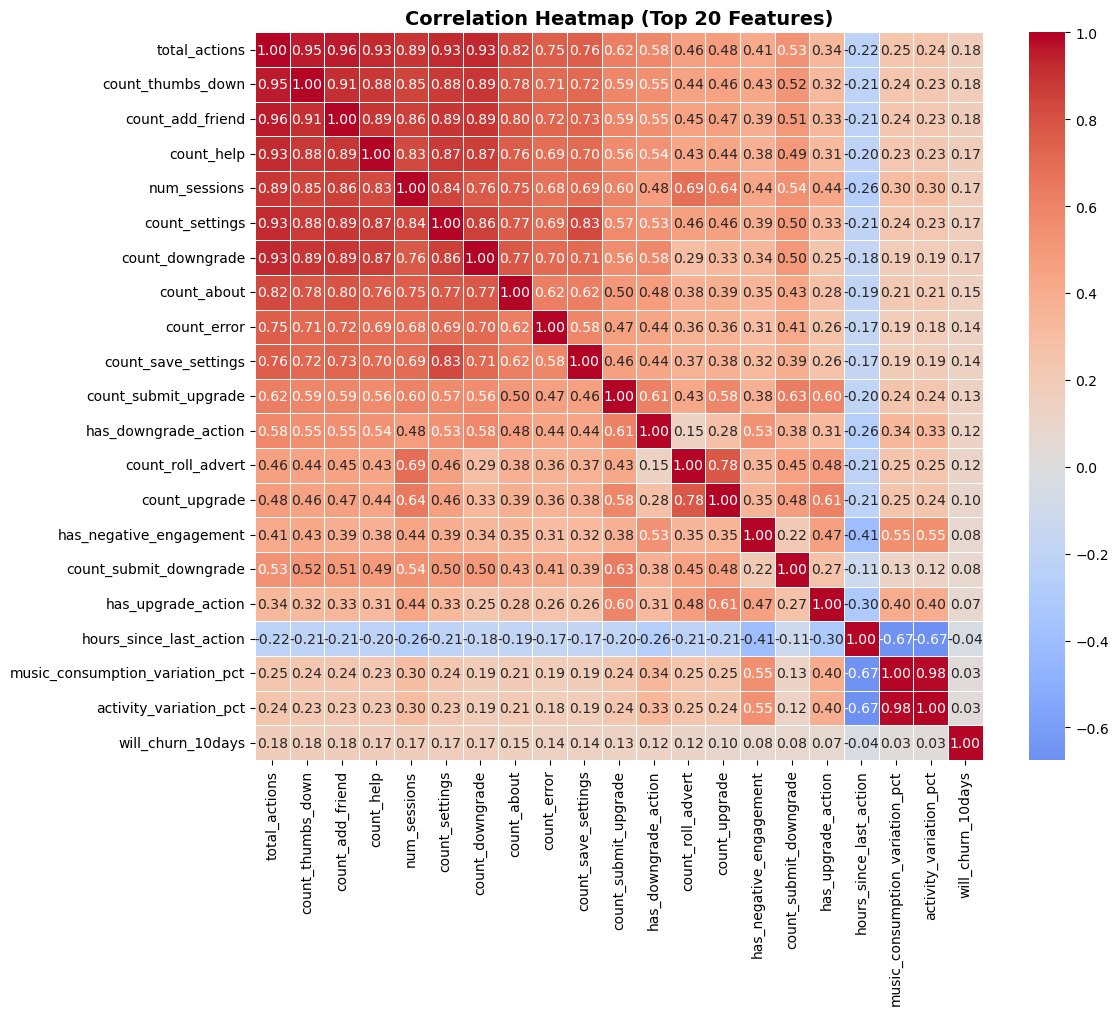

In [72]:
plot_correlation_heatmap(df_consistant)

### First training with Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

def random_forest_training(df_features):
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    print(f"Features: {len(feature_cols)}")
    print(f"Dataset size: {len(X)}")
    print(f"Label distribution:\n{y.value_counts(normalize=True)}")

    # Split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train Random Forest with better parameters for imbalanced data
    model = RandomForestClassifier(
        n_estimators=100,           # Number of trees
        max_depth=15,               # Limit depth to avoid overfitting
        min_samples_split=10,       # Minimum samples to split a node
        min_samples_leaf=5,         # Minimum samples in a leaf
        class_weight='balanced',    # CRITICAL: Handle class imbalance
        random_state=42,
        n_jobs=-1                   # Use all CPU cores
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of churn

    # Evaluation with appropriate metrics
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    print(f"\nAccuracy: {model.score(X_test, y_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    print("\nTop 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(10).to_string(index=False))
    return model

In [74]:
random_forest_training(df_consistant)

Features: 24
Dataset size: 119755
Label distribution:
will_churn_10days
0    0.892272
1    0.107728
Name: proportion, dtype: float64

MODEL EVALUATION

Accuracy: 0.8674
F1-Score: 0.4443
ROC-AUC: 0.7911

Confusion Matrix:
[[19504  1867]
 [ 1310  1270]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.91      0.92     21371
       Churn       0.40      0.49      0.44      2580

    accuracy                           0.87     23951
   macro avg       0.67      0.70      0.68     23951
weighted avg       0.88      0.87      0.87     23951


Top 10 Most Important Features:
                feature  importance
days_since_registration    0.105895
hours_since_last_action    0.099243
          total_actions    0.087923
             like_ratio    0.086968
              skip_rate    0.073177
      count_thumbs_down    0.066636
       count_add_friend    0.062170
      count_roll_advert    0.055790
           num_sessions    0.055761
    

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, min_samples_split=10, n_jobs=-1,
                       random_state=42)

We need to deal with classe imbalance

### Second try with XG Boost

In [75]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np

def XGB_training(df_features):

    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    # Split (NO resampling here!)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate scale_pos_weight: ratio of negative to positive class
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    print(f"Class distribution in train:")
    print(y_train.value_counts())
    print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

    # XGBoost with optimal parameters for churn prediction
    model = xgb.XGBClassifier(
        # Handle imbalanced classes
        scale_pos_weight=scale_pos_weight,  # CRITICAL for imbalanced data
        
        # Model complexity
        n_estimators=200,                   # Number of boosting rounds
        max_depth=6,                        # Tree depth (prevent overfitting)
        learning_rate=0.05,                 # Lower = more robust but slower
        
        # Regularization
        min_child_weight=5,                 # Minimum sum of weights in a child
        gamma=0.1,                          # Minimum loss reduction for split
        subsample=0.8,                      # Fraction of samples per tree
        colsample_bytree=0.8,               # Fraction of features per tree
        reg_alpha=0.1,                      # L1 regularization
        reg_lambda=1.0,                     # L2 regularization
        
        # Optimization
        objective='binary:logistic',        # Binary classification
        eval_metric='auc',                  # MOVED HERE: Use AUC for evaluation
        early_stopping_rounds=20,           # MOVED HERE: Stop if no improvement
        random_state=42,
        n_jobs=-1
    )

    # Train (simplified - no need to pass eval_metric again)
    print("\nTraining XGBoost model...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10  # Print progress every 10 rounds
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)

    print(f"\nAccuracy: {model.score(X_test, y_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    import pandas as pd
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))

    # Best iteration (from early stopping)
    print(f"\nBest iteration: {model.best_iteration}")
    print(f"Best score (AUC on validation): {model.best_score:.4f}")

In [76]:
XGB_training(df_consistant)

Class distribution in train:
will_churn_10days
0    85483
1    10321
Name: count, dtype: int64

Calculated scale_pos_weight: 8.28

Training XGBoost model...
[0]	validation_0-auc:0.69552	validation_1-auc:0.68227
[10]	validation_0-auc:0.72170	validation_1-auc:0.70026
[20]	validation_0-auc:0.72939	validation_1-auc:0.70549
[30]	validation_0-auc:0.73647	validation_1-auc:0.71018
[40]	validation_0-auc:0.74409	validation_1-auc:0.71520
[50]	validation_0-auc:0.74964	validation_1-auc:0.71817
[60]	validation_0-auc:0.75553	validation_1-auc:0.72137
[70]	validation_0-auc:0.76096	validation_1-auc:0.72508
[80]	validation_0-auc:0.76620	validation_1-auc:0.72826
[90]	validation_0-auc:0.77034	validation_1-auc:0.73024
[100]	validation_0-auc:0.77569	validation_1-auc:0.73303
[110]	validation_0-auc:0.78054	validation_1-auc:0.73649
[120]	validation_0-auc:0.78617	validation_1-auc:0.73935
[130]	validation_0-auc:0.79028	validation_1-auc:0.74206
[140]	validation_0-auc:0.79525	validation_1-auc:0.74521
[150]	validati

### Rebalance the classes with a SMOTE function

In [77]:
# We apply smote only to train sets
def apply_smote(df_features):
    """
    Apply SMOTE to balance classes.
    """
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                   if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"Before SMOTE: {len(y_train)} samples")
    print(f"After SMOTE:  {len(y_train_balanced)} samples")
    print(f"Class 0: {(y_train_balanced==0).sum()}, Class 1: {(y_train_balanced==1).sum()}")
    
    return X_train_balanced, y_train_balanced, X_test, y_test

In [78]:
X_train_balanced, y_train_balanced, X_test, y_test = apply_smote(df_consistant)

Before SMOTE: 95804 samples
After SMOTE:  170966 samples
Class 0: 85483, Class 1: 85483


In [79]:
def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train Random Forest and evaluate.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, roc_auc_score
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    return rf, roc_auc

In [80]:
model_rf_SMOTED, score = train_random_forest(X_train_balanced, y_train_balanced, X_test, y_test)

ROC-AUC: 0.8140

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.89      0.92     21371
       Churn       0.38      0.56      0.45      2580

    accuracy                           0.85     23951
   macro avg       0.66      0.73      0.68     23951
weighted avg       0.88      0.85      0.87     23951

